# Moran-HOG ion image clustering workflow

#### Demo notebook - February 2024 - LEM Tideman - TU Delft
#### Zebra-fish dataset

In [1]:
import pickle
import h5py
import time
import random
import scipy.io
import warnings
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [2]:
import moran_imaging.Moran_HOG_clustering as MHOG
from moran_imaging.ARI_balance import balanced_adjusted_rand_index
import moran_imaging.deep_clustering as DC
from moran_imaging.plotting import position_discrete_colorbar_ticks

C:\Users\Leo\anaconda3\envs\cookiecutter_env_final_final_final\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Seaborn plotting style
sns.set(style="whitegrid",font_scale=1.5)

colormap_scatterplot = ListedColormap(['#ff85a5', 'black', 'lightskyblue', 'white'])
colormap_scatterplot_binary = ListedColormap(['#ff85a5', 'lightskyblue'])

sns.set(style="whitegrid", font_scale=1)
colormap_reverse = sns.blend_palette([".99", "darkblue"], as_cmap=True)

In [4]:
def reshape_array(y_data, image_shape, pixel_index, fill_zeros=False):
    """
    Reshape 1D data to 2D heatmap
    Parameters
    ----------
    y_data: np.array / list
    1D array of values to be reshaped
    image_shape: tuple
    final shape of the image
    pixel_index: np.array
    array containing positions where pixels should be placed, considering missing values - e.g. not acquired pixels
    fill_zeros: bool 
    determines whether missing values should be filled with NaNs or 0s
    check_orientation : bool
    if True, image will be rotated to ensure the width is larger than the height
    
    Return
    zvals: np.array
    reshaped heatmap of shape `image_shape`
    """
    image_n_pixels = np.prod(image_shape)
    xy_vals = np.zeros(image_n_pixels, dtype=np.float64)
    
    # replace zeros with NaNs
    if not fill_zeros:
        xy_vals[xy_vals == 0] = np.nan
        
    # put data in the correct place
    for i, idx in enumerate(pixel_index):
        xy_vals[idx] = y_data[i]
        
    # reshape data
    zvals = np.reshape(xy_vals, image_shape)
    
    return zvals

In [5]:
def make_ion_image(data, image_shape, background_mask, fill_zeros=True, show_image=True, colormap='coolwarm'):
    
    # Fill background pixels with zeros (default) or NaN
    pixel_grid = np.zeros((image_shape[0]*image_shape[1], ))
    pixel_grid[np.invert(background_mask)] = data
    
    if not fill_zeros:
        pixel_grid[background_mask] = np.nan
    
    # Reshape data
    ion_image = np.reshape(pixel_grid, image_shape)
    
    # Plot ion image 
    if show_image == True: 
        plt.figure(dpi=100)
        plt.imshow(ion_image, cmap=colormap)
        plt.axis('off')
        plt.show()
        
    return ion_image

In [6]:
def summary_visualization_per_cluster(cluster_num, cluster_indices, dataset, MHOG_cluster_model, feature_index=None): 
    # Random selection of one ion image from the given cluster
    if feature_index is None:
        feature_index = random.choice(cluster_indices[cluster_num]) 
    feature_mz = mz_per_cluster[cluster_num][feature_index-np.min(cluster_indices[cluster_num])]

    # Initialize figure 
    fig = plt.figure(figsize=(6, 10), dpi=150)
    gridspec = plt.GridSpec(3, 1)
    plt.tight_layout()

    # Ion image
    axes_mini = fig.add_subplot(gridspec[0]) 
    ion_image_flat = dataset[:, feature_index]
    ion_image = make_ion_image(ion_image_flat, image_shape, background_mask, fill_zeros=False, show_image=False)
    mini_fig = axes_mini.imshow(ion_image, vmin=np.nanpercentile(ion_image, 1), vmax=np.nanpercentile(ion_image, 99), cmap=colormap_reverse)
    axes_mini.set_title("\n a) Ion image of m/z " + str(np.round(feature_mz, 3)), y=-0.18, fontsize=13, fontweight="bold")
    axes_mini.axis("off")
    cbar = fig.colorbar(mini_fig, ax=axes_mini, orientation="horizontal", fraction=0.055, pad=0.15, aspect=36)
    cbar.set_label("Signal intensity")
    cbar.ax.tick_params(labelsize=12)

    # Moran quadrant map
    axes_mini = fig.add_subplot(gridspec[1]) 
    Moran_quadrant_demo = MHOG_cluster_model.Moran_quadrants[np.invert(background_mask), feature_index] 
    Moran_quadrant_map = make_ion_image(Moran_quadrant_demo, image_shape, background_mask, fill_zeros=False, show_image=False) 
    mini_fig = plt.imshow(Moran_quadrant_map, cmap=colormap_scatterplot, interpolation=None) 
    axes_mini.set_title("\n c) Moran quadrant map of m/z " + str(np.round(feature_mz, 3)), y=-0.18, fontsize=13, fontweight="bold")
    axes_mini.axis("off")
    tick_labels = ['High intensity \n'+'High spatial lag', 'Low intensity \n'+'High spatial lag', 'Low intensity \n'+'Low spatial lag', 'High intensity \n'+'Low spatial lag']
    tick_loc = position_discrete_colorbar_ticks(1, 4)
    cbar_total = plt.colorbar(mini_fig, ax=axes_mini, ticks=tick_loc, orientation='horizontal', fraction=0.055, pad=0.15, aspect=36, drawedges=True)
    cbar_total.ax.set_xticklabels(tick_labels)
    cbar_total.outline.set_color('black')
    cbar_total.dividers.set_color('black')
    cbar_total.dividers.set_linewidth(1)
    cbar_total.outline.set_linewidth(1)

    # HOG feature map of Moran quadrant map
    axes_mini = fig.add_subplot(gridspec[2]) 
    Moran_quadrant_map_HOG_features = MHOG_cluster_model.Moran_quadrants_HOG_images.transpose()[np.invert(background_mask), feature_index]
    HOG_image = make_ion_image(Moran_quadrant_map_HOG_features, image_shape, background_mask, fill_zeros=False, show_image=False)
    mini_fig = axes_mini.imshow(HOG_image, vmin=np.nanpercentile(HOG_image, 1), vmax=np.nanpercentile(HOG_image, 99), cmap='binary')
    axes_mini.set_title("\n d) Histogram of oriented gradients of the Moran quadrant map", y=-0.18, fontsize=13, fontweight="bold")
    axes_mini.axis("off")
    cbar = fig.colorbar(mini_fig, ax=axes_mini, orientation="horizontal", fraction=0.055, pad=0.15, aspect=36)
    cbar.set_label("HOG value")

    fig.savefig("./Figures/Summary_figure_cluster_" + str(cluster_num), bbox_inches="tight")
    plt.show()

### Load imaging mass spectrometry data

In [7]:
# Load dataset
with open('Data/Zebra_fish_8_clusters_dataset.pickle', 'rb') as file:
    clustering_data_metadata = pickle.load(file) 

image_shape = clustering_data_metadata['utils']['image_shape']
background_mask = clustering_data_metadata['utils']['background_mask']
data_cluster1 = clustering_data_metadata['cluster_1']['data'] 
data_cluster2 = clustering_data_metadata['cluster_2']['data']
data_cluster3 = clustering_data_metadata['cluster_3']['data']
data_cluster4 = clustering_data_metadata['cluster_4']['data']
data_cluster5 = clustering_data_metadata['cluster_5']['data']
data_cluster6 = clustering_data_metadata['cluster_6']['data']
data_cluster7 = clustering_data_metadata['cluster_7']['data']
data_cluster8 = clustering_data_metadata['cluster_8']['data']

In [8]:
dataset = np.hstack((data_cluster1, data_cluster2, data_cluster3, data_cluster4, data_cluster5, data_cluster6, data_cluster7, data_cluster8))

ref_labels = ([1]*data_cluster1.shape[1] + [2]*data_cluster2.shape[1] + [3]*data_cluster3.shape[1] + [4]*data_cluster4.shape[1] + [5]*data_cluster5.shape[1] +
              [6]*data_cluster6.shape[1] + [7]*data_cluster7.shape[1] + [8]*data_cluster8.shape[1])

total_num_pixels = np.prod(image_shape)
num_mz_bins = dataset.shape[1]

#### Moran-HOG clustering

In [9]:
MHOG_cluster_model = MHOG.Moran_HOG_SKD_clustering(dataset, np.invert(background_mask), image_shape, HOG_visualize=True, random_seed=42)
MHOG_HDBSCAN_labels = MHOG_cluster_model.clustering_HDBSCAN(min_cluster_size=5, max_cluster_size=50)
MHOG_k_means_labels = MHOG_cluster_model.clustering_k_means(num_clusters=8)

Extracting HOG Features: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 174/174 [06:04<00:00,  2.10s/it]


In [10]:
# Clustering performance with HDBSCAN clustering
ARI_HDBSCAN = np.round(adjusted_rand_score(ref_labels, MHOG_HDBSCAN_labels), 4)
print(ARI_HDBSCAN)
AMI_HDBSCAN = np.round(adjusted_mutual_info_score(ref_labels, MHOG_HDBSCAN_labels, average_method='arithmetic'), 4)
print(AMI_HDBSCAN)
BARI_HDBSCAN = np.round(balanced_adjusted_rand_index(np.array(ref_labels), np.array(MHOG_HDBSCAN_labels)), 4)
print(BARI_HDBSCAN)

0.7667
0.8608
0.7881


In [11]:
# Clustering performance with k-means clustering
ARI_k_means = np.round(adjusted_rand_score(ref_labels, MHOG_k_means_labels), 4)
print(ARI_k_means)
AMI_k_means = np.round(adjusted_mutual_info_score(ref_labels, MHOG_k_means_labels, average_method='arithmetic'), 4)
print(AMI_k_means)
BARI_k_means = np.round(balanced_adjusted_rand_index(np.array(ref_labels), np.array(MHOG_k_means_labels)), 4)
print(BARI_k_means)

0.8272
0.8879
0.8535


#### Moran-HOG visualization 
Plot one ion image per cluster with its Moran quadrant map and the corresponding HOG image

In [12]:
# Store cluster indices
cluster_indices = {i: [] for i in range(1, 9)}
for idx, label in enumerate(ref_labels):
    cluster_indices[label].append(idx)

# Mass-to-charge ratios of the molecular species in each cluster
mz_per_cluster = {}
mz_per_cluster[1] = clustering_data_metadata['cluster_1']['mz']
mz_per_cluster[2] = clustering_data_metadata['cluster_2']['mz']
mz_per_cluster[3] = clustering_data_metadata['cluster_3']['mz']
mz_per_cluster[4] = clustering_data_metadata['cluster_4']['mz']
mz_per_cluster[5] = clustering_data_metadata['cluster_5']['mz']
mz_per_cluster[6] = clustering_data_metadata['cluster_6']['mz']
mz_per_cluster[7] = clustering_data_metadata['cluster_7']['mz']
mz_per_cluster[8] = clustering_data_metadata['cluster_8']['mz']

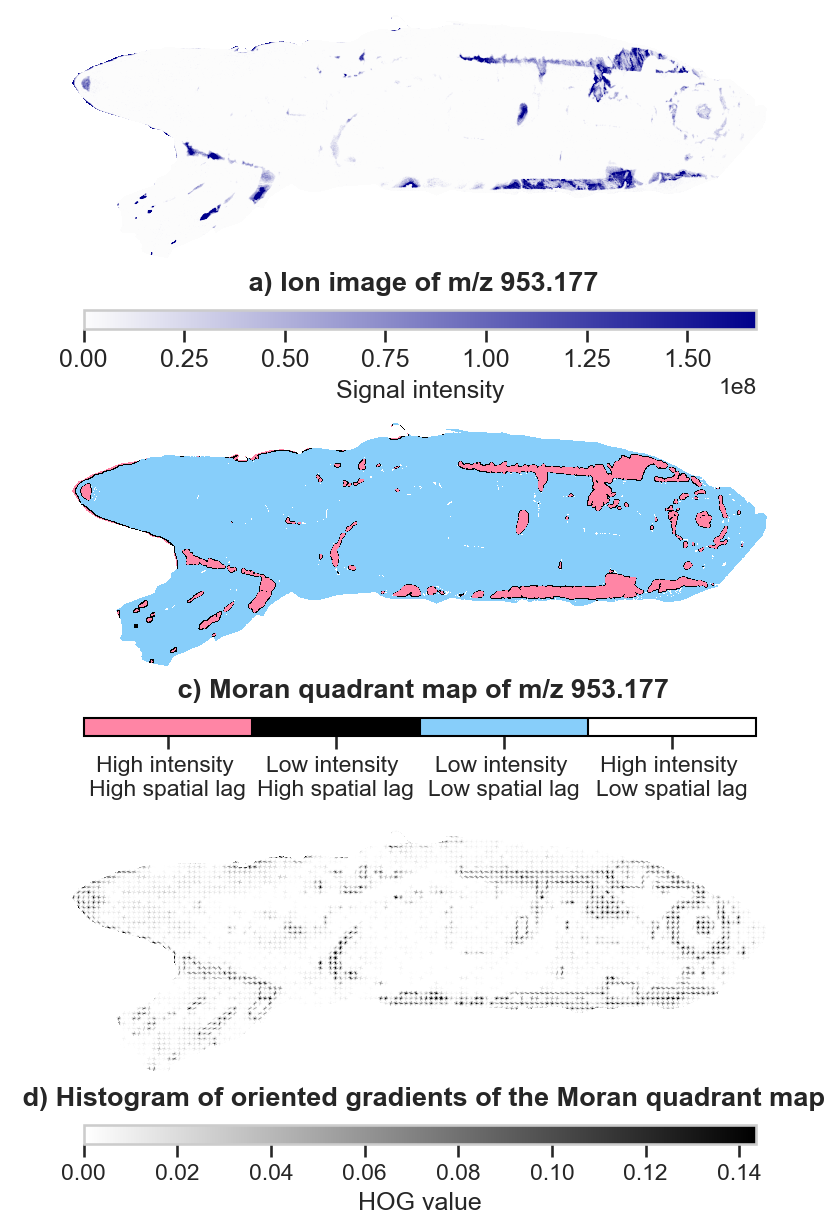

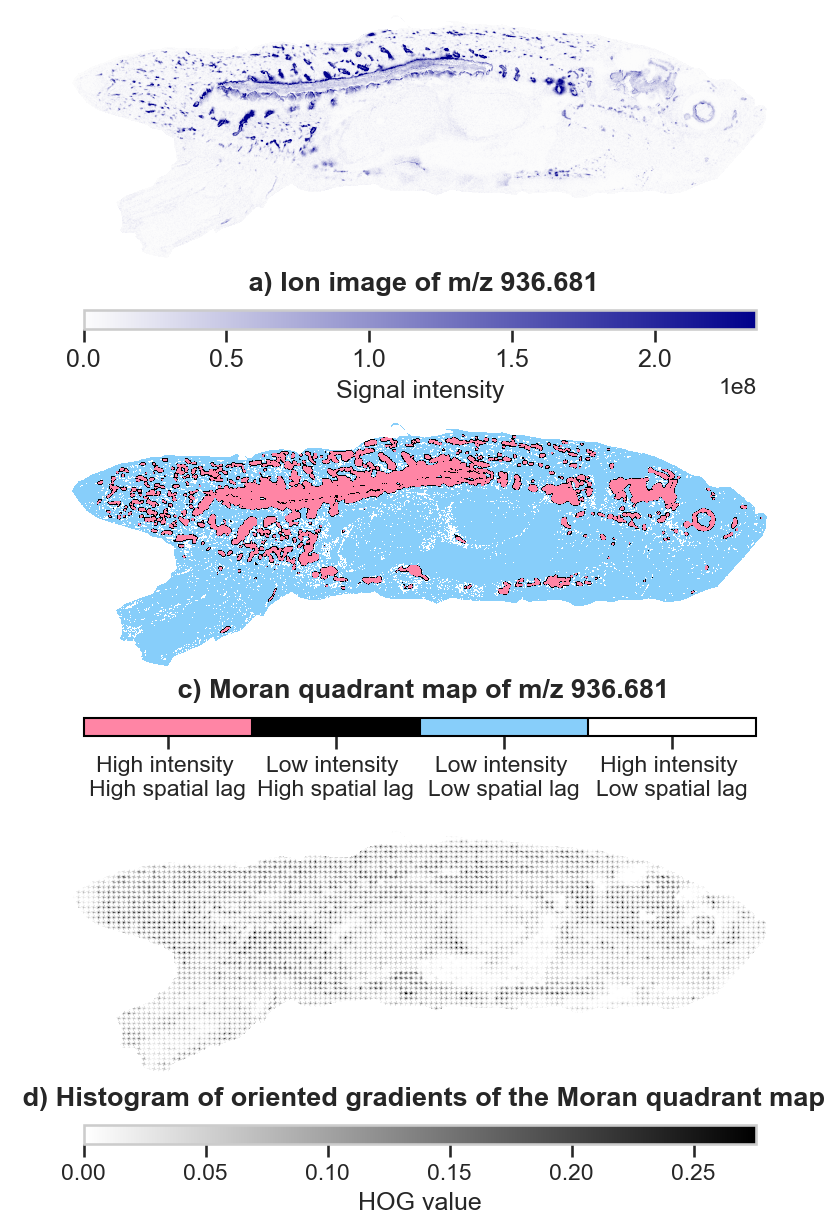

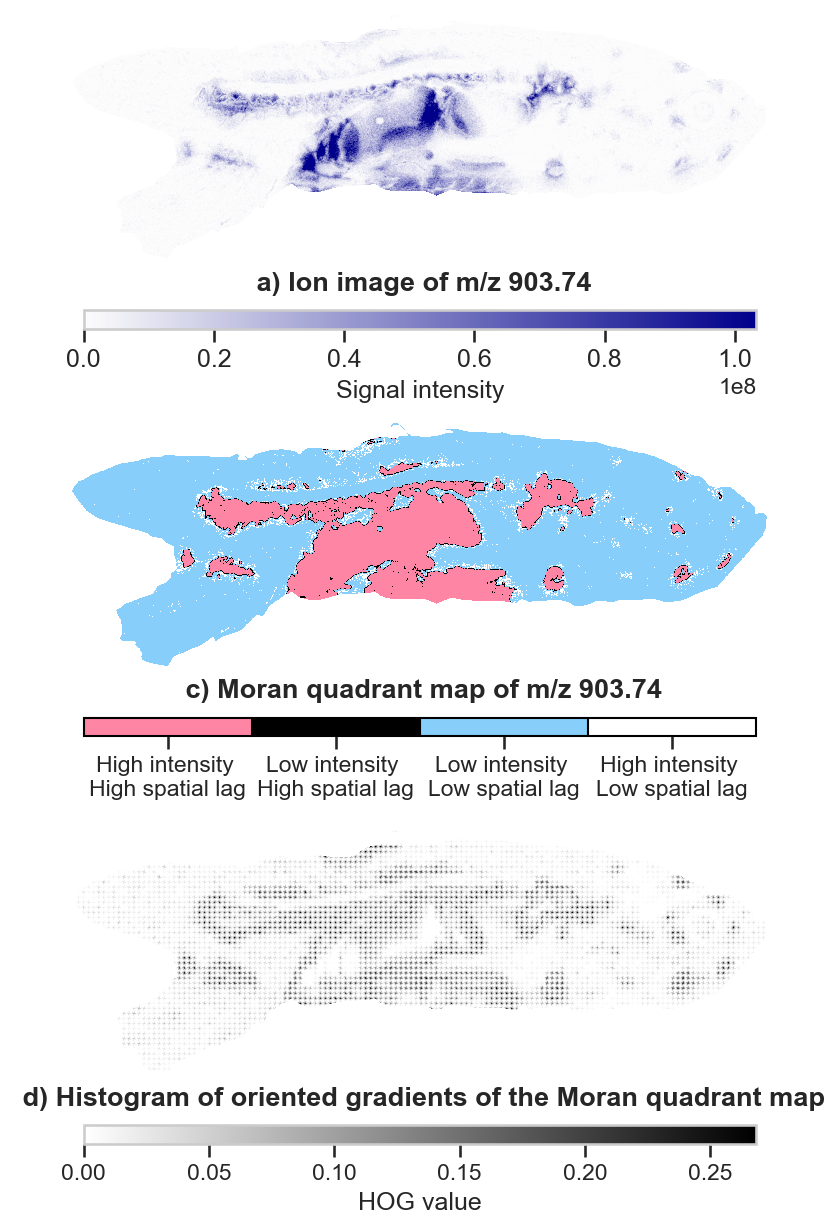

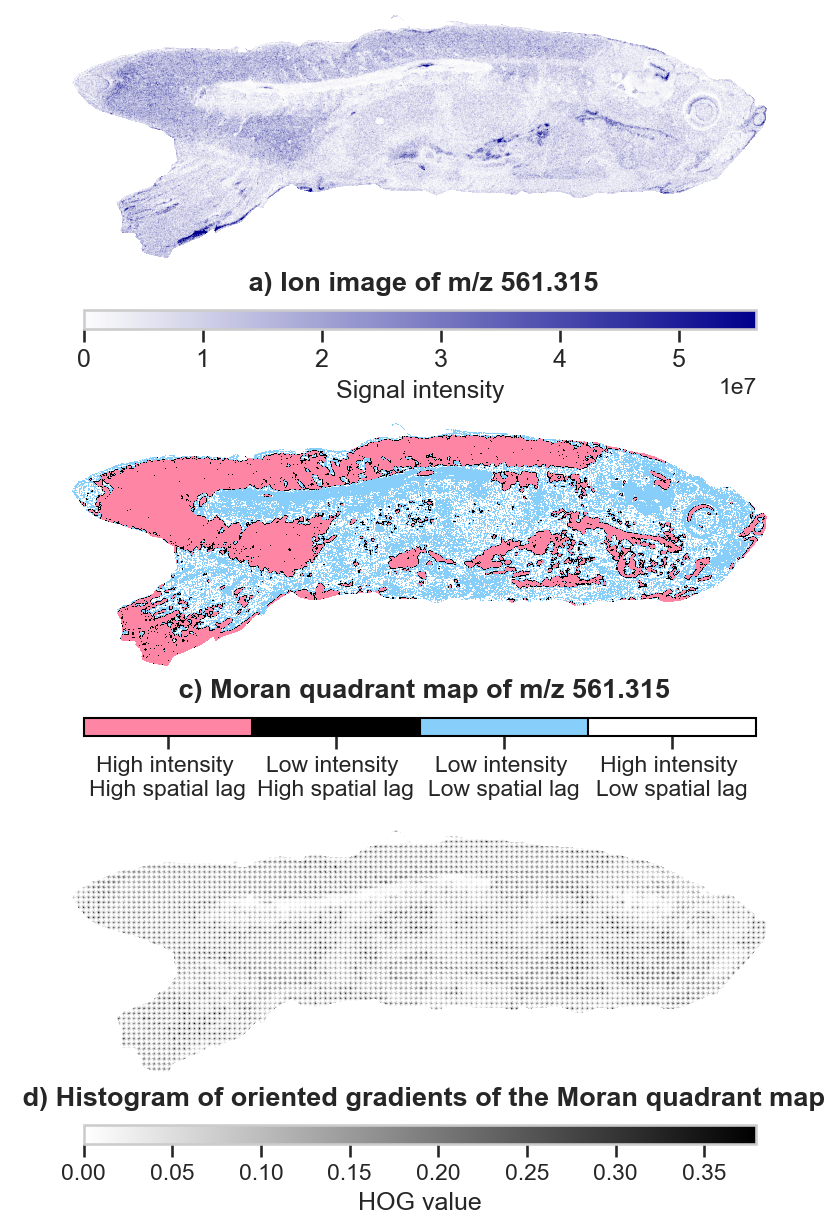

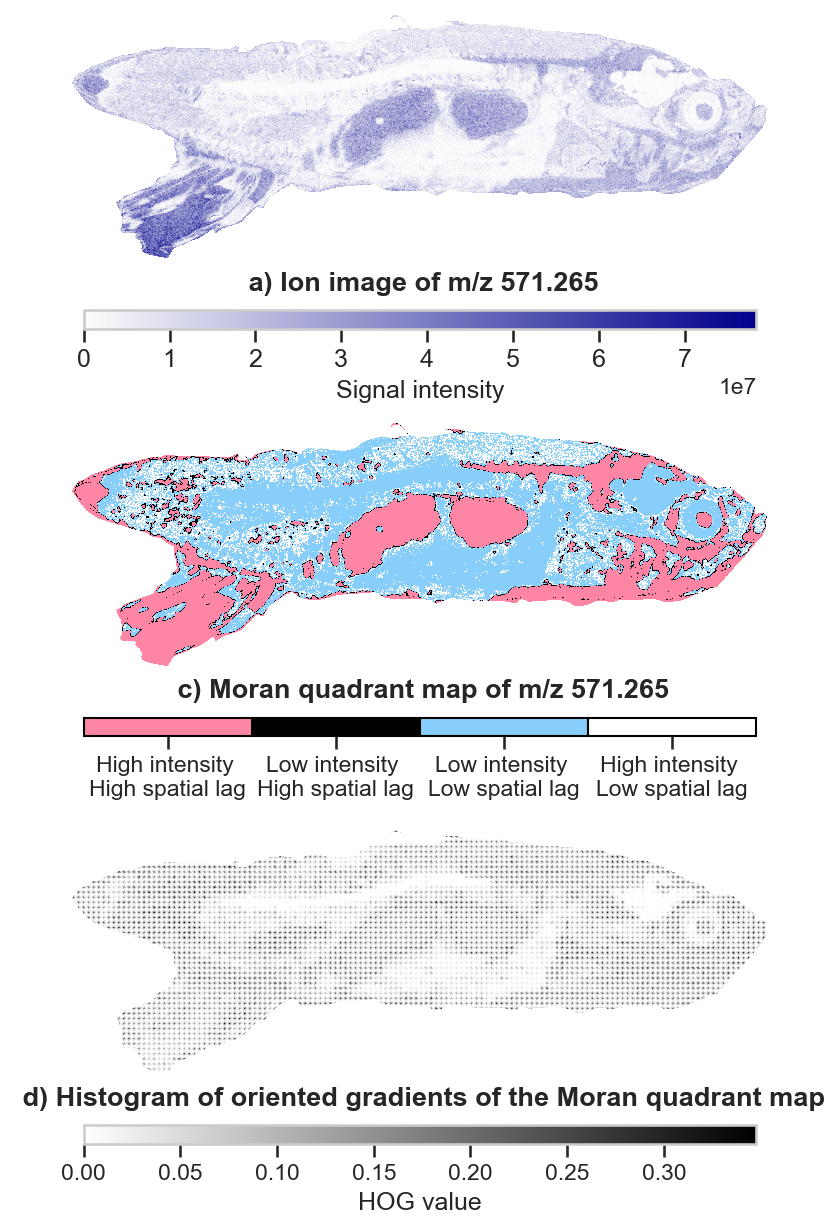

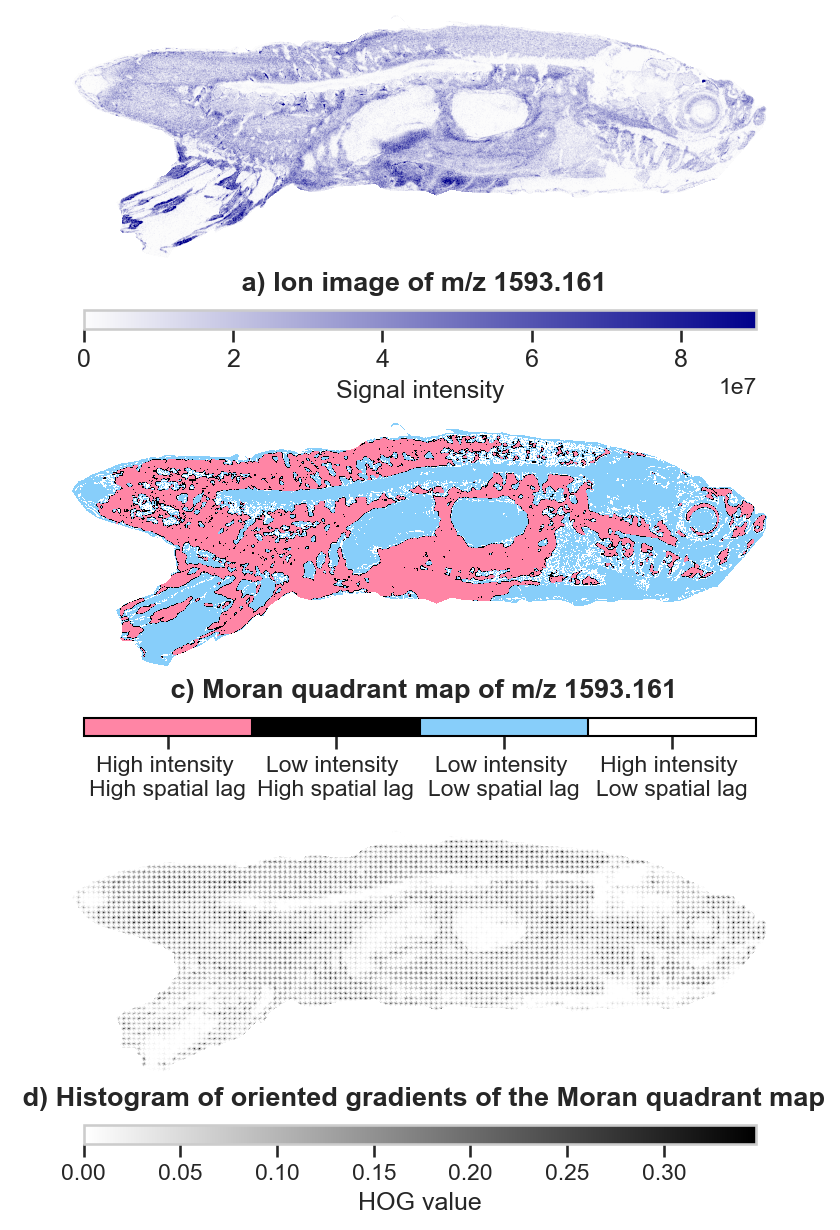

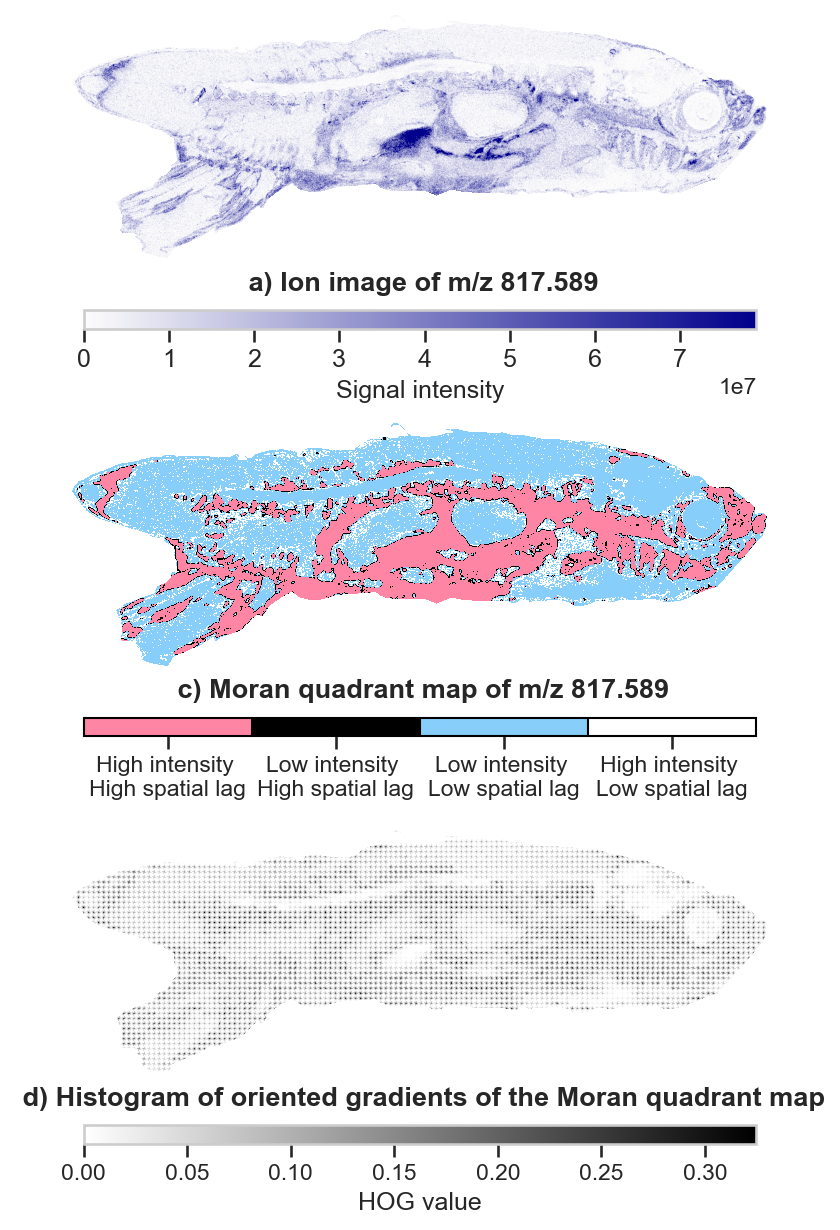

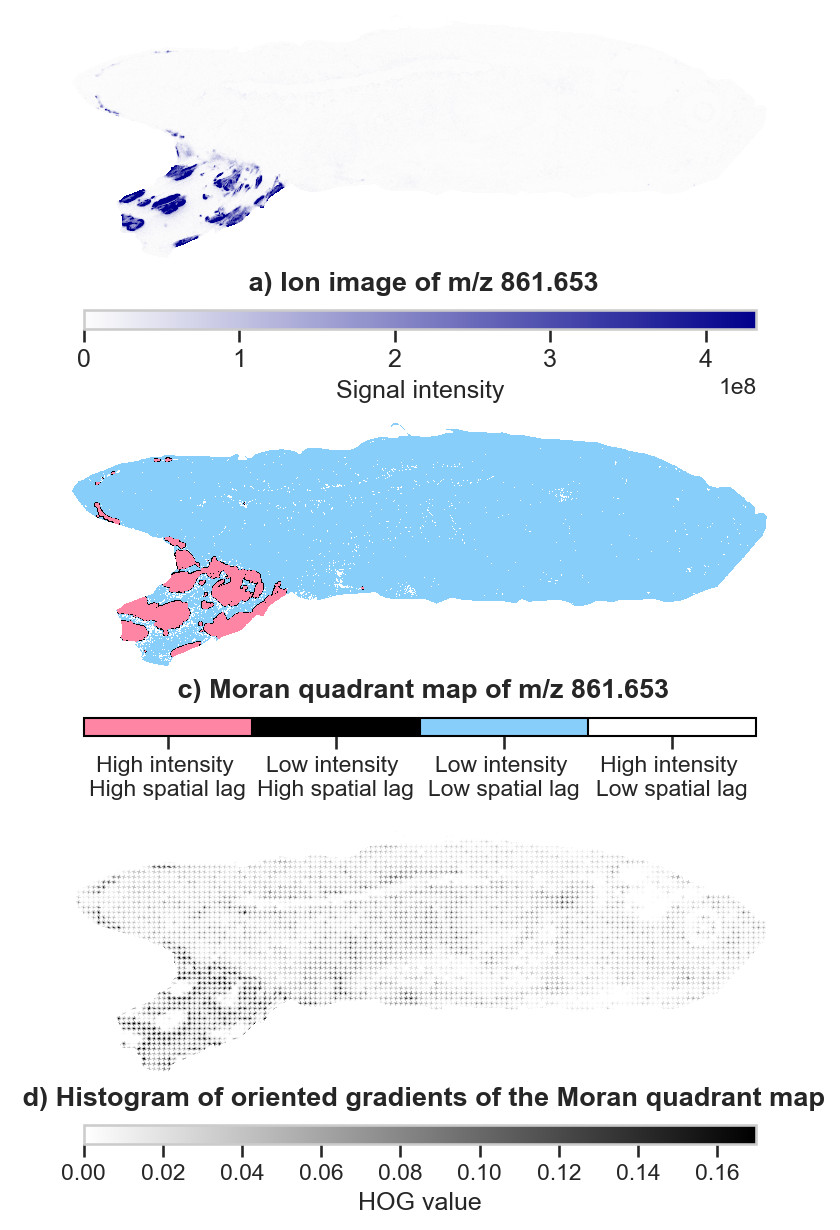

In [13]:
random.seed(0)
for cluster_num in range(1, 9): 
    summary_visualization_per_cluster(cluster_num, cluster_indices, dataset, MHOG_cluster_model)

#### Deep clustering

In [ ]:
# If you have access to a GPU, set use_gpu to True
DC_cluster_model = DC.Deep_Clustering(dataset, np.invert(background_mask), image_shape, num_cluster=8, lr=0.0001, knn=True, k=5, use_gpu=False, random_seed=0)
cae, CLUST = DC_cluster_model.train()
DC_labels = DC_cluster_model.inference(cae, CLUST)

In [ ]:
# Deep clustering performance 
ARI_DC = np.round(adjusted_rand_score(ref_labels, DC_labels), 4)
print(ARI_DC)
AMI_DC = np.round(adjusted_mutual_info_score(ref_labels, DC_labels, average_method='arithmetic'), 4)
print(AMI_DC)
ARI_DC = np.round(balanced_adjusted_rand_index(np.array(ref_labels), np.array(DC_labels)), 4)
print(ARI_DC)